In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
file_path = 'clean_output.csv'
data = pd.read_csv(file_path)

In [4]:
need = ['old/new', 'town/city', 'district', 'county', 'year', 'month',
       'day', 'property_type_is__D', 'property_type_is__F',
       'property_type_is__O', 'property_type_is__S', 'property_type_is__T']

In [5]:
lin_df = data.copy()
lin_df.head()

,price,old/new,town/city,district,county,year,month,day,property_type_is__D,property_type_is__F,property_type_is__O,property_type_is__S,property_type_is__T
0,199950,1,ANDOVER,TEST VALLEY,HAMPSHIRE,2013,12,13,0,0,0,0,1
1,76000,0,BRIDLINGTON,EAST RIDING OF YORKSHIRE,EAST RIDING OF YORKSHIRE,2013,8,2,0,0,0,0,1
2,200000,0,CANTERBURY,DOVER,KENT,2013,9,20,0,0,0,1,0
3,125000,0,MINEHEAD,WEST SOMERSET,SOMERSET,2013,8,30,0,1,0,0,0
4,135000,0,CANTERBURY,CANTERBURY,KENT,2013,12,6,0,0,0,0,1


 Converting the values of specific columns into numerical representations.

In [6]:
lin_df['town/city'] = lin_df['town/city'].factorize()[0].astype('float32')
lin_df['district'] = lin_df['district'].factorize()[0].astype('float32')
lin_df['county'] = lin_df['county'].factorize()[0].astype('float32')


Detect and remove outliers from lin_df, keeping only the rows identified as inliers based on a contamination rate of 5%.

In [8]:
from sklearn.ensemble import IsolationForest

iso = IsolationForest(contamination=0.05, random_state=42)  # 5% contamination
outliers = iso.fit_predict(lin_df)
lin_df = lin_df[outliers == 1]  # Keep only inliers

In [ ]:
from sklearn.model_selection import train_test_split
X = lin_df[need]
y = lin_df['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

In [ ]:
print(X_train.shape, y_train.shape)

(1194366, 12) (1194366,)


Standardizes the specified columns in X_train by scaling them to have a mean of 0 and a standard deviation of 1 for better code performance.

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

normalized_array = scaler.fit_transform(X_train[need])
normalized_X_train = pd.DataFrame(normalized_array, columns=need)

normalized_X_train

,old/new,town/city,district,county,year,month,day,property_type_is__D,property_type_is__F,property_type_is__O,property_type_is__S,property_type_is__T
0,-0.281709,-0.947717,-1.077930,-0.469758,-1.945522,1.055134,-1.012521,-0.526926,-0.497438,-0.085977,-0.612163,1.511687
1,-0.281709,1.931710,-0.288230,-1.158757,0.844986,0.760495,1.227973,-0.526926,-0.497438,-0.085977,1.633552,-0.661513
2,-0.281709,-0.472550,-0.031834,1.379660,1.775155,-0.123421,-1.012521,-0.526926,-0.497438,-0.085977,-0.612163,1.511687
3,3.549758,-0.972084,-1.129209,-1.049968,-0.085183,0.171217,-0.004299,1.897800,-0.497438,-0.085977,-0.612163,-0.661513
4,-0.281709,-0.760899,-0.636928,0.618135,-1.015352,0.465856,-1.012521,-0.526926,-0.497438,-0.085977,-0.612163,1.511687
...,...,...,...,...,...,...,...,...,...,...,...,...
1194361,-0.281709,-0.813695,-0.483091,-0.796126,-1.015352,-1.301977,-0.564422,-0.526926,-0.497438,-0.085977,1.633552,-0.661513
1194362,-0.281709,0.014800,0.973239,-0.288443,-0.085183,-0.418060,1.339998,-0.526926,-0.497438,-0.085977,-0.612163,1.511687
1194363,-0.281709,0.055412,1.034774,2.286238,-1.015352,0.465856,-1.236571,-0.526926,2.010300,-0.085977,-0.612163,-0.661513
1194364,-0.281709,-0.582204,-0.247206,-1.158757,1.775155,-0.712699,0.779874,1.897800,-0.497438,-0.085977,-0.612163,-0.661513


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
import numpy as np

# Define the parameter distribution for RandomizedSearchCV
param_dist = {
    'max_depth': [3, 5, 10, None],  # Possible depths
    'min_samples_split': [2, 5, 10, 20],  # Minimum samples needed to split a node
    'min_samples_leaf': [1, 5, 10, 20],  # Minimum samples required in a leaf node
    'max_features': [None, 'sqrt', 'log2'],  # Limit the number of features considered
}

# Initialize the DecisionTreeRegressor
tr_regressor = DecisionTreeRegressor(random_state=42)

# Perform RandomizedSearchCV for hyperparameter optimization
random_search = RandomizedSearchCV(
    estimator=tr_regressor,
    param_distributions=param_dist,
    n_iter=60,  # Limit to 100 fits
    cv=5,  # 5-fold cross-validation
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available CPU cores
    random_state=42,  # Ensure reproducibility
    verbose=1  # Display progress
)

# Fit RandomizedSearchCV on the training data
random_search.fit(normalized_X_train, y_train)

# Get the best model from RandomizedSearchCV
best_regressor = random_search.best_estimator_

# Display the best parameters and score
print("Best Parameters:", random_search.best_params_)
print("Best Cross-Validation R^2 Score:", random_search.best_score_)

# Evaluate the best model with cross-validation
avg_tr_score = cross_val_score(best_regressor, normalized_X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R^2 Scores for Best Model:", avg_tr_score)
print("Average R^2 Score for Best Model:", avg_tr_score.mean())


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters: {'min_samples_split': 10, 'min_samples_leaf': 20, 'max_features': None, 'max_depth': None}
Best Cross-Validation R^2 Score: 0.6189309890812591
Cross-Validation R^2 Scores for Best Model: [0.61881607 0.61903991 0.62033254 0.61524092 0.62122551]
Average R^2 Score for Best Model: 0.6189309890812591


Fitting 5 folds for each of 36 candidates, totalling 180 fits


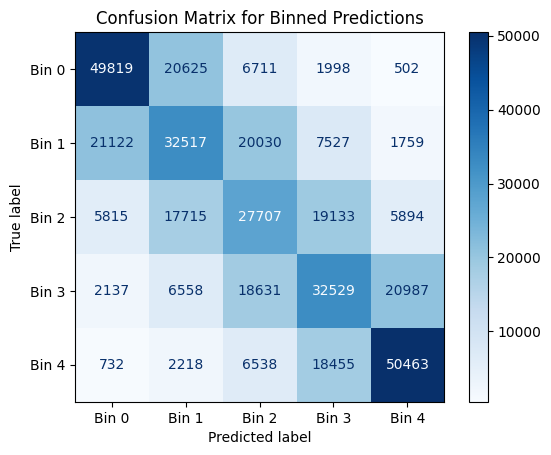

In [ ]:
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'max_depth': [3, 5, 10, None],  # Limit tree depth to prevent overfitting
    'min_samples_split': [2, 5, 10],  # Minimum samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum samples required in a leaf node
}

# Initialize the DecisionTreeRegressor with a random state for reproducibility
tr_regressor = DecisionTreeRegressor(random_state=42)

# Use GridSearchCV to find the best hyperparameters
grid_search = GridSearchCV(
    estimator=tr_regressor,
    param_grid=param_grid,
    scoring='r2',  # Use R^2 as the scoring metric
    n_jobs=-1,  # Use all available CPU cores
    verbose=1  # Show progress
)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Retrieve the best estimator and its score
best_regressor = grid_search.best_estimator_

# **Confusion Matrix Visualization**
# Define the number of bins for discretizing the values
num_bins = 5

# Bin the actual and predicted values into categories
actual_bins = pd.qcut(y_test, num_bins, labels=False)  # Binning actual values
predicted_bins = pd.qcut(y_test_pred, num_bins, labels=False)  # Binning predicted values

# Compute the confusion matrix
cm = confusion_matrix(actual_bins, predicted_bins)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[f'Bin {i}' for i in range(num_bins)])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Binned Predictions')
plt.show()
